In [1]:
from itertools import product, combinations
from functools import partial

import numpy as np
from tqdm import tqdm
import uproot
from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from scipy.stats import norm, poisson
from iminuit import Minuit, util
from iminuit.cost import LeastSquares
from scipy.interpolate import interp1d
from tqdm import tqdm
from sklearn.preprocessing import normalize

plt.rcParams['font.size'] = 10
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.dpi'] = 100

In [2]:
nCellxy = 100
showerr = 100
sourcez = -5000

In [3]:
file = '/tmp/gamma.root'
fileelectron = '/tmp/electron.root'
filepi0 = '/tmp/pi0.root'

In [4]:
f = uproot.open(file)

In [5]:
f.keys()

['Energy3D;1', 'XYZ;1', 'Truth;1', 'Energy2D;1', 'XY;1']

In [6]:
energy2d = uproot.open(file + ':' + 'Energy2D')
xy = uproot.open(file + ':' + 'XY')
truth = uproot.open(file + ':' + 'Truth')

In [7]:
deposit2d = np.vstack([energy2d[e].array(library='np') for e in tqdm(energy2d.keys())])
position2d = np.vstack([xy[e].array(library='np') for e in tqdm(xy.keys())])
truthexy = np.vstack([truth[e].array(library='np') for e in tqdm(truth.keys())])

100%|██████████| 6/6 [00:00<00:00, 1156.36it/s]


# Incident truth

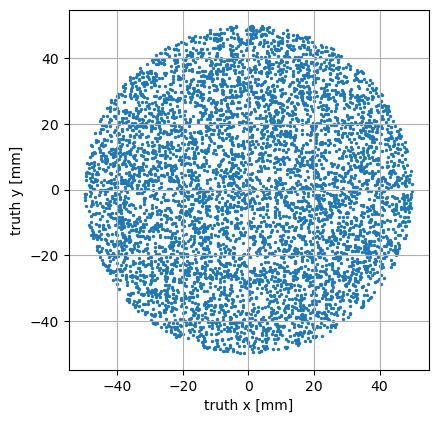

In [8]:
fig = plt.figure(figsize=(4, 4))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.2, hspace=0.25)
ax = fig.add_subplot(gs[0, 0])

ax.scatter(truthexy[4], truthexy[5], s=2)
ax.grid()
ax.set_xlabel('truth x [mm]')
ax.set_ylabel('truth y [mm]')
plt.show()

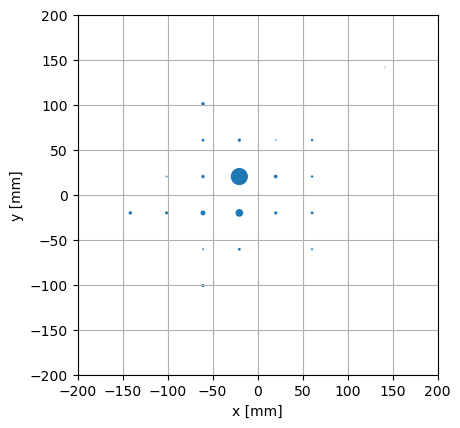

In [9]:
i = 0

fig = plt.figure(figsize=(4, 4))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.2, hspace=0.25)
ax = fig.add_subplot(gs[0, 0])
ax.grid()
ax.scatter(position2d[0, :nCellxy], position2d[1:, :nCellxy], s=deposit2d[:, i])
ax.set_xlim(-200, 200)
ax.set_ylim(-200, 200)
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')

plt.show()

# Reconstruction

## Position reconstruction

In [10]:
cellr = np.sqrt(position2d[0] ** 2 + position2d[1] ** 2)

In [11]:
reconenergy = np.empty(deposit2d.shape[1])
reconposition = np.empty((2, deposit2d.shape[1]))

for i in range(deposit2d.shape[1]):
    vali = np.sqrt((position2d[0, :nCellxy] - position2d[0, :nCellxy][deposit2d[:, i].argmax()]) ** 2 + 
                   (position2d[1, :nCellxy] - position2d[1, :nCellxy][deposit2d[:, i].argmax()]) ** 2) < showerr
    reconenergy[i] = deposit2d[:, i][vali].sum()
    reconposition[:, i] = np.matmul(position2d[:, :nCellxy], np.where(vali, deposit2d[:, i], 0)) / reconenergy[i]

In [12]:
# reconposition = np.matmul(position2d[:, :nCellxy], deposit2d) / reconenergy
deltaxy = reconposition - truthexy[4:, :]

In [13]:
deltar = np.sqrt(deltaxy[0] ** 2 + deltaxy[1] ** 2)

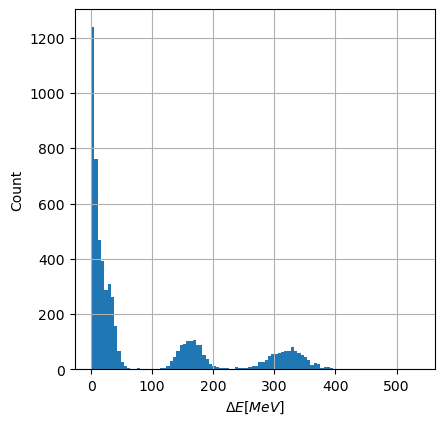

In [14]:
fig = plt.figure(figsize=(4, 4))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.2, hspace=0.25)
ax = fig.add_subplot(gs[0, 0])
ax.hist(deposit2d.sum(axis=0) - reconenergy, bins=100)
ax.grid()
ax.set_xlabel(r'$\Delta E [MeV]$')
ax.set_ylabel('Count')
plt.show()

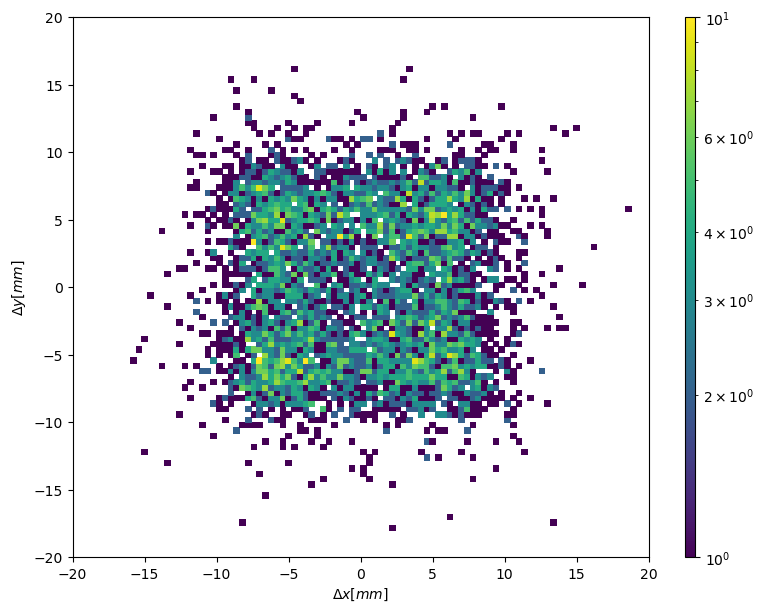

In [15]:
fig = plt.figure(figsize=(8, 6))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.2, hspace=0.25)
ax = fig.add_subplot(gs[0, 0])
h = ax.hist2d(deltaxy[0], deltaxy[1], bins=(np.linspace(-20, 20, 101), np.linspace(-20, 20, 101)), norm=LogNorm())
fig.colorbar(h[3], ax=ax, aspect=50)
ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)
ax.set_xlabel('$\Delta x [mm]$')
ax.set_ylabel('$\Delta y [mm]$')

plt.show()

In [16]:
def loglikelihood(mu, sigma, obs, bins):
    exp = np.diff(norm.cdf(bins, loc=mu, scale=sigma)) * obs.sum()
    # like = np.sum((obs - exp)**2 / obs)
    like = -poisson.logpmf(obs, mu=exp).sum()
    return like

In [17]:
energyunique, energyindex = np.unique(truthexy[0], return_index=True)

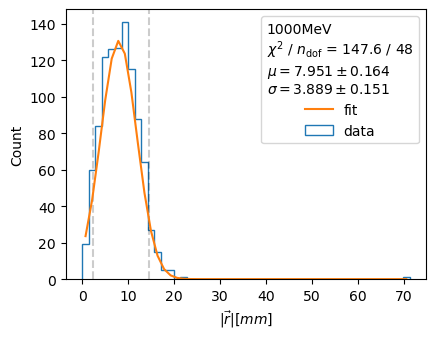

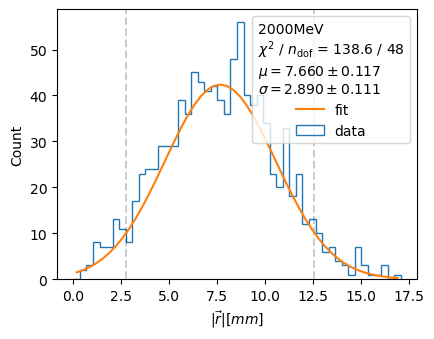

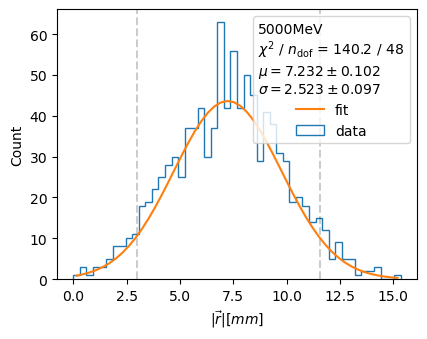

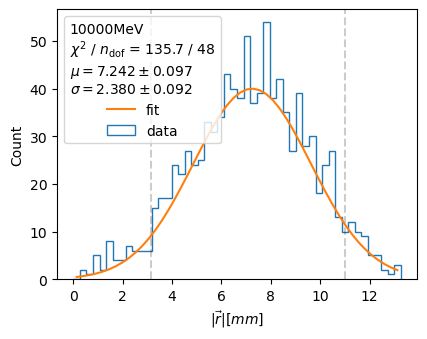

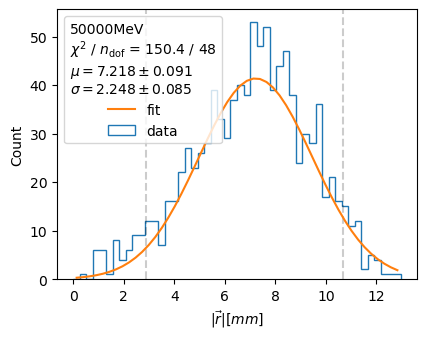

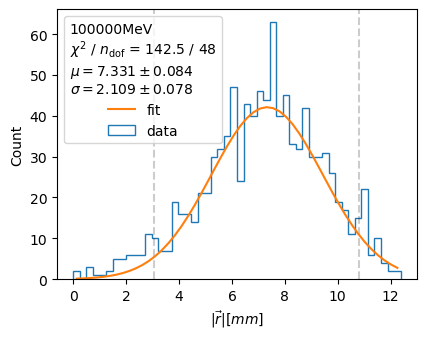

In [18]:
posmu = np.empty((len(energyunique), 2))
possigma = np.empty((len(energyunique), 2))

for i, e in enumerate(energyunique):
    fig = plt.figure(figsize=(4, 3))
    # fig.tight_layout()
    gs = gridspec.GridSpec(1, 1, figure=fig, left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.2, hspace=0.25)
    ax = fig.add_subplot(gs[0, 0])
    deltari = deltar[truthexy[0] == e]
    bins = np.linspace(0, deltari.max(), 51)
    fitbins = np.linspace(np.quantile(deltari, 0.05), np.quantile(deltari, 0.95), 51) #@
    h = ax.hist(deltari, bins=bins, histtype='step', label='data')
    ax.axvline(x=fitbins[0], color='k', linestyle='dashed', alpha=0.2)
    ax.axvline(x=fitbins[-1], color='k', linestyle='dashed', alpha=0.2)
    c, b = np.histogram(deltari, bins=fitbins)
    m = Minuit(partial(loglikelihood, obs=c, bins=fitbins), mu=deltar.mean(), sigma=deltar.std(ddof=-1), name=('mu', 'sigma'))
    m.errordef = Minuit.LIKELIHOOD
    m.limits['mu'] = (0, e)
    m.limits['sigma'] = (0, np.inf)
    m.migrad()
    m.migrad()
    m.migrad()
    m.hesse()
    posmu[i, 0] = m.values[0]
    posmu[i, 1] = m.errors[0]
    possigma[i, 0] = m.values[1]
    possigma[i, 1] = m.errors[1]
    
    fit_info = [str(int(e)) + 'MeV', f'$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(bins) - 1 - m.nfit}', 
                f'$\mu = {m.values[0]:.3f} \\pm {m.errors[0]:.3f}$', f'$\sigma = {m.values[1]:.3f} \\pm {m.errors[1]:.3f}$']
    ax.plot((bins[1:] + bins[:-1]) / 2, np.diff(norm.cdf(bins, loc=posmu[i, 0], scale=possigma[i, 0])) * c.sum(), label='fit')
    ax.set_xlabel(r'$|\vec{r}| [mm]$')
    ax.set_ylabel('Count')
    ax.legend(title='\n'.join(fit_info))
    plt.show()

## Energy calibration

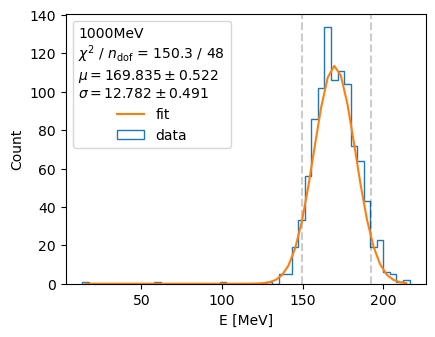

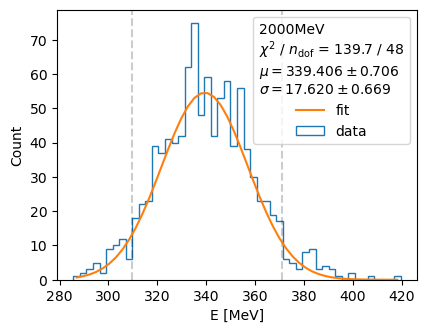

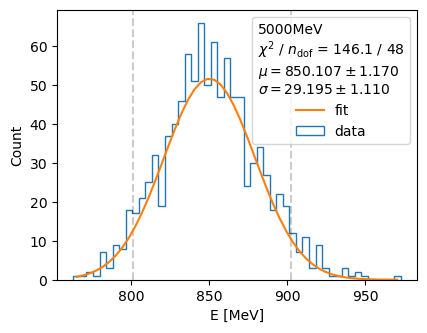

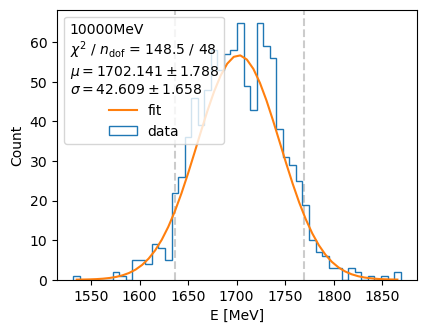

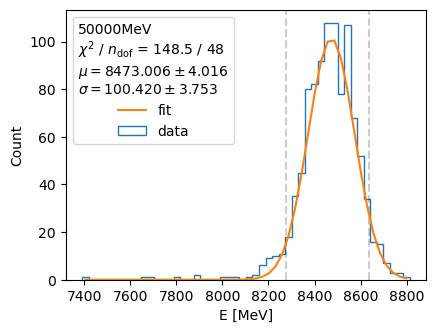

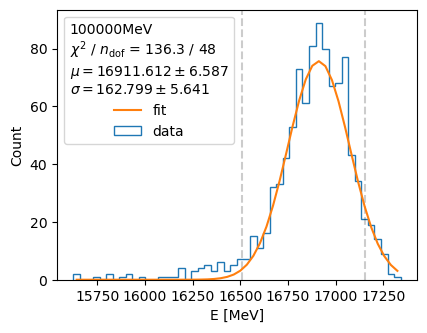

In [19]:
mu = np.empty((len(energyunique), 2))
sigma = np.empty((len(energyunique), 2))

for i, e in enumerate(energyunique):
    fig = plt.figure(figsize=(4, 3))
    # fig.tight_layout()
    gs = gridspec.GridSpec(1, 1, figure=fig, left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.2, hspace=0.25)
    ax = fig.add_subplot(gs[0, 0])
    reconenergyi = reconenergy[truthexy[0] == e]
    bins = np.linspace(reconenergyi.min(), reconenergyi.max(), 51)
    fitbins = np.linspace(np.quantile(reconenergyi, 0.05), np.quantile(reconenergyi, 0.95), 51) #@
    h = ax.hist(reconenergyi, bins=bins, histtype='step', label='data')
    ax.axvline(x=fitbins[0], color='k', linestyle='dashed', alpha=0.2)
    ax.axvline(x=fitbins[-1], color='k', linestyle='dashed', alpha=0.2)
    c, b = np.histogram(reconenergyi, bins=fitbins)
    m = Minuit(partial(loglikelihood, obs=c, bins=fitbins), mu=reconenergyi.mean(), sigma=reconenergyi.std(ddof=-1), name=('mu', 'sigma'))
    m.errordef = Minuit.LIKELIHOOD
    m.limits['mu'] = (0, e)
    m.limits['sigma'] = (0, np.inf)
    m.migrad()
    m.migrad()
    m.migrad()
    m.hesse()
    mu[i, 0] = m.values[0]
    mu[i, 1] = m.errors[0]
    sigma[i, 0] = m.values[1]
    sigma[i, 1] = m.errors[1]
    
    fit_info = [str(int(e)) + 'MeV', f'$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(bins) - 1 - m.nfit}', f'$\mu = {m.values[0]:.3f} \\pm {m.errors[0]:.3f}$', f'$\sigma = {m.values[1]:.3f} \\pm {m.errors[1]:.3f}$']
    ax.plot((bins[1:] + bins[:-1]) / 2, np.diff(norm.cdf(bins, loc=mu[i, 0], scale=sigma[i, 0])) * c.sum(), label='fit')
    ax.set_xlabel('E [MeV]')
    ax.set_ylabel('Count')
    ax.legend(title='\n'.join(fit_info))
    plt.show()

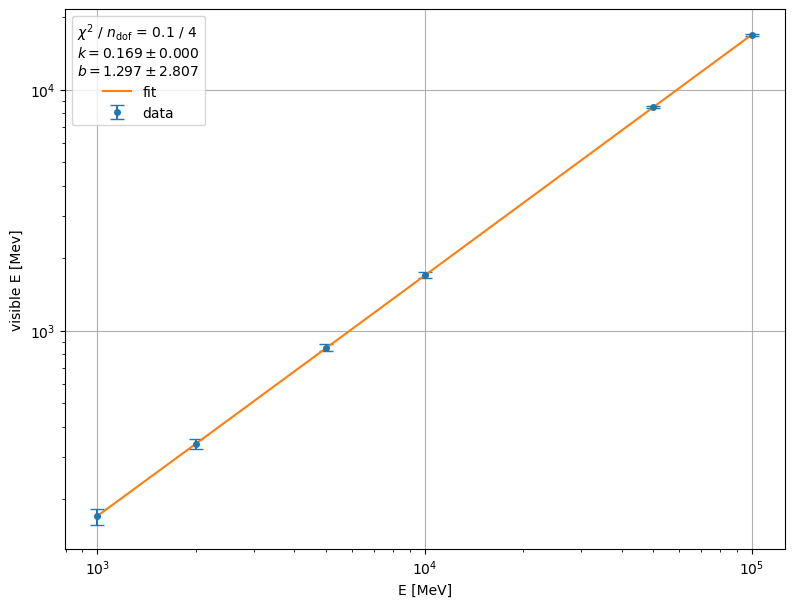

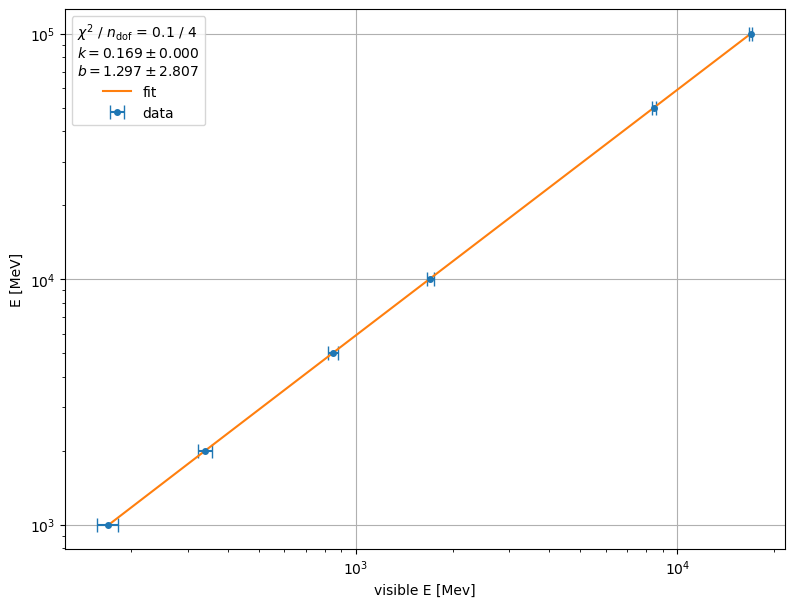

In [20]:
def calibrationline(x, k, b):
    return b + x * k

least_squares = LeastSquares(energyunique, mu[:, 0], sigma[:, 0], calibrationline)

m = Minuit(least_squares, k=0, b=0)
m.migrad()
m.hesse()
fit_info = [f'$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(energyunique) - m.nfit}', 
            f'$k = {m.values[0]:.3f} \\pm {m.errors[0]:.3f}$', 
            f'$b = {m.values[1]:.3f} \\pm {m.errors[1]:.3f}$']

calib = dict(k=1 / m.values[0], b=-m.values[1] / m.values[0])

fig = plt.figure(figsize=(8, 6))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.2, hspace=0.25)
ax = fig.add_subplot(gs[0, 0])
ax.errorbar(energyunique, mu[:, 0], yerr=sigma[:, 0], capsize=5, markersize=4, fmt='o', label='data')
ax.plot(energyunique, calibrationline(energyunique, *m.values), label='fit')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('E [MeV]')
ax.set_ylabel('visible E [Mev]')
ax.grid()
ax.legend(title='\n'.join(fit_info), loc='upper left')

plt.show()

fig = plt.figure(figsize=(8, 6))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.2, hspace=0.25)
ax = fig.add_subplot(gs[0, 0])
ax.errorbar(mu[:, 0], energyunique, xerr=sigma[:, 0], capsize=5, markersize=4, fmt='o', label='data')
ax.plot(calibrationline(energyunique, *m.values), energyunique, label='fit')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('visible E [Mev]')
ax.set_ylabel('E [MeV]')
ax.grid()
ax.legend(title='\n'.join(fit_info), loc='upper left')

plt.show()

In [21]:
print('Energy calibration is: E = {:.3f} * visE {:.3f}'.format(calib['k'], calib['b']))

Energy calibration is: E = 5.906 * visE -7.661


In [22]:
califnc = np.poly1d([calib['k'], calib['b']])

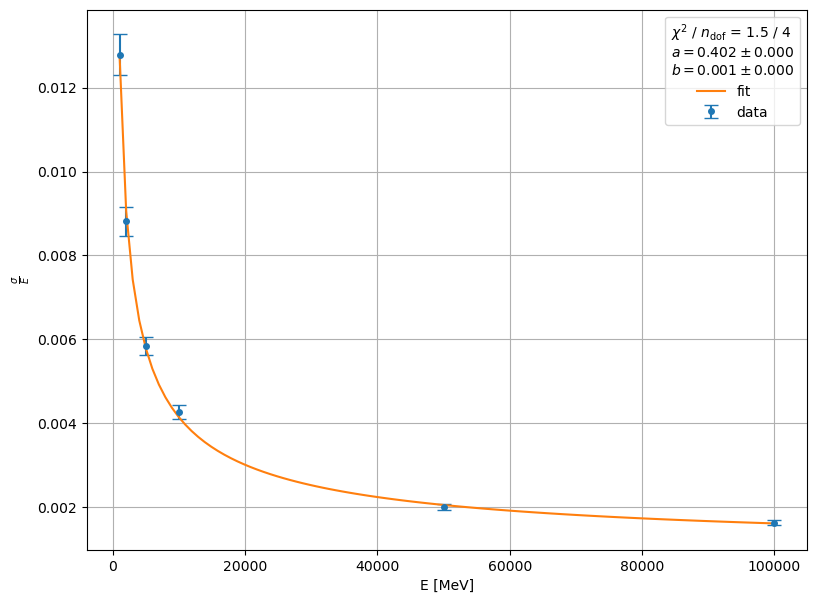

In [23]:
def sigmaline(x, a, b):
    return np.sqrt(a ** 2 / x + b**2)

least_squares = LeastSquares(energyunique, sigma[:, 0] / energyunique, sigma[:, 1] / energyunique, sigmaline)

m = Minuit(least_squares, a=0.4, b=1e-3)
m.migrad()
m.hesse()
fit_info = [f'$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(energyunique) - m.nfit}', 
            f'$a = {m.values[0]:.3f} \\pm {m.errors[0]:.3f}$', 
            f'$b = {m.values[1]:.3f} \\pm {m.errors[1]:.3f}$']

fig = plt.figure(figsize=(8, 6))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.2, hspace=0.25)
ax = fig.add_subplot(gs[0, 0])
ax.errorbar(energyunique, sigma[:, 0] / energyunique, yerr=sigma[:, 1] / energyunique, capsize=5, markersize=4, fmt='o', label='data')
ax.plot(np.linspace(energyunique.min(), energyunique.max(), 101), sigmaline(np.linspace(energyunique.min(), energyunique.max(), 101), *m.values), label='fit')
ax.set_xlabel('E [MeV]')
ax.set_ylabel(r'$\frac{\sigma}{E}$')
ax.grid()
ax.legend(title='\n'.join(fit_info), loc='upper right')

plt.show()

# Molière radius

In [24]:
energy2delectron = uproot.open(fileelectron + ':' + 'Energy2D')
xyelectron = uproot.open(fileelectron + ':' + 'XY')
truthelectron = uproot.open(fileelectron + ':' + 'Truth')

In [25]:
deposit2delectron = np.vstack([energy2delectron[e].array(library='np') for e in tqdm(energy2delectron.keys())])
position2delectron = np.vstack([xyelectron[e].array(library='np') for e in tqdm(xyelectron.keys())])
truthexyelectron = np.vstack([truthelectron[e].array(library='np') for e in tqdm(truthelectron.keys())])

100%|██████████| 6/6 [00:00<00:00, 6725.23it/s]


In [26]:
moliere_r = np.empty(deposit2delectron.shape[1])
cellr = np.sqrt(position2delectron[0] ** 2 + position2delectron[1] ** 2)

In [27]:
reconenergyelectron = np.empty(deposit2delectron.shape[1])

for i in range(deposit2delectron.shape[1]):
    reconenergyelectron[i] = deposit2delectron[:, i][np.sqrt((position2delectron[0, :nCellxy] - position2delectron[0, :nCellxy][deposit2delectron[:, i].argmax()]) ** 2 + 
                                                             (position2delectron[1, :nCellxy] - position2delectron[1, :nCellxy][deposit2delectron[:, i].argmax()]) ** 2) < showerr].sum()

In [28]:
reconpositionelectron = np.matmul(position2delectron[:, :nCellxy], deposit2delectron) / reconenergyelectron
deltaxyelectron = reconpositionelectron - truthexyelectron[4:, :]

In [29]:
for i in tqdm(range(deposit2delectron.shape[1])):
    r_list = np.linspace(0, 300, 1001)
    reconx = position2delectron[0, :nCellxy][deposit2delectron[:, i].argmax()]
    recony = position2delectron[1, :nCellxy][deposit2delectron[:, i].argmax()]
    # reconx = deltaxyelectron[0, i]
    # recony = deltaxyelectron[1, i]
    cellr = np.sqrt((position2delectron[0, :nCellxy] - reconx) ** 2 + 
                    (position2delectron[1, :nCellxy] - recony) ** 2)
    ratio = np.array([deposit2delectron[:, i][cellr < r].sum() / deposit2delectron[:, i].sum() for r in r_list])
    moliere_r[i] = interp1d(ratio, r_list)(0.9)

100%|██████████| 1000/1000 [00:05<00:00, 188.17it/s]


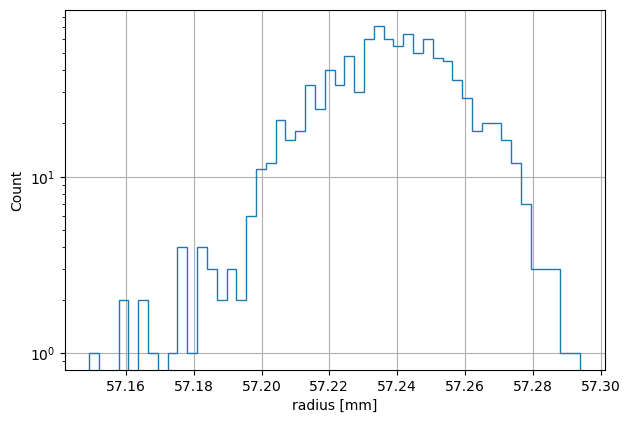

Moliere radius is 57.24mm


In [30]:
max_r = 80

fig = plt.figure(figsize=(6, 4))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.2, hspace=0.25)
ax = fig.add_subplot(gs[0, 0])
bins = np.linspace(moliere_r[moliere_r < max_r].min(), moliere_r[moliere_r < max_r].max(), 51)
h = ax.hist(moliere_r[moliere_r < max_r], bins=bins, histtype='step', label='data')
ax.set_xlabel('radius [mm]')
ax.set_ylabel('Count')
ax.set_yscale('log')
ax.grid()
plt.show()
print('Moliere radius is {:.2f}mm'.format(moliere_r[moliere_r < max_r].mean()))

# $\pi^0$ 3D scatter

In [31]:
energy3dpi0 = uproot.open(filepi0 + ':' + 'Energy3D')
xyzpi0 = uproot.open(filepi0 + ':' + 'XYZ')

In [32]:
deposit3d = np.vstack([energy3dpi0[e].array(library='np') for e in tqdm(energy3dpi0.keys())])
position3d = np.vstack([xyzpi0[e].array(library='np') for e in tqdm(xyzpi0.keys())])

100%|██████████| 3/3 [00:00<00:00, 3884.81it/s]


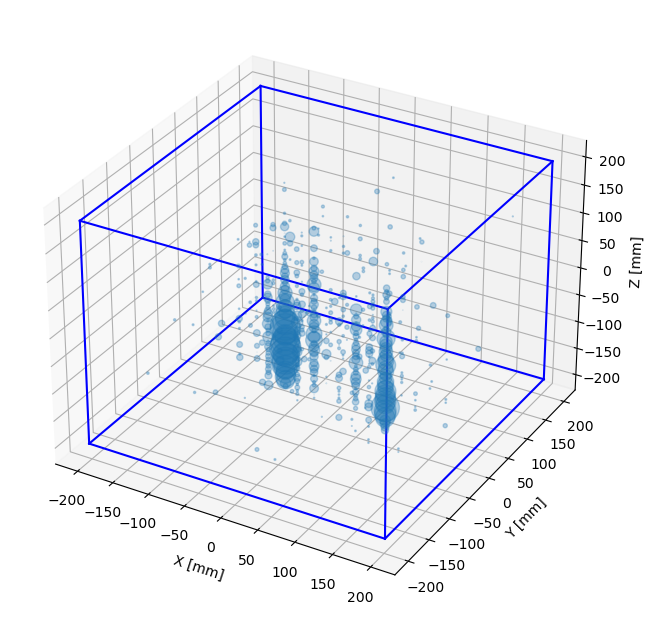

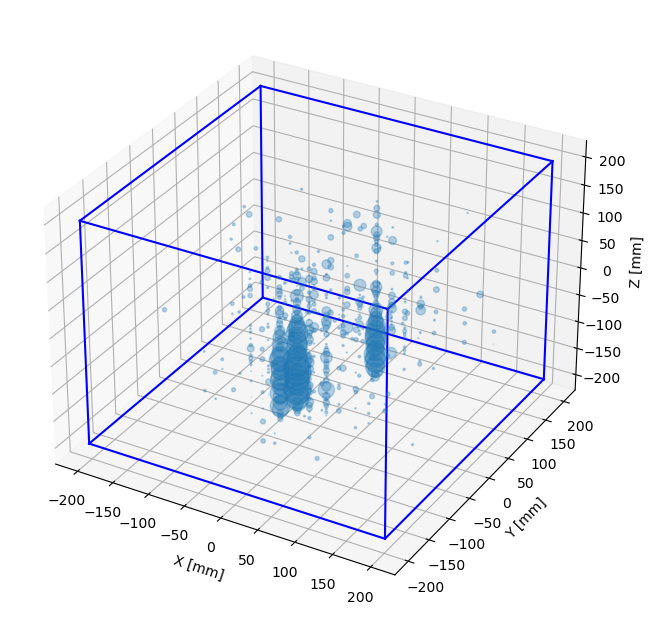

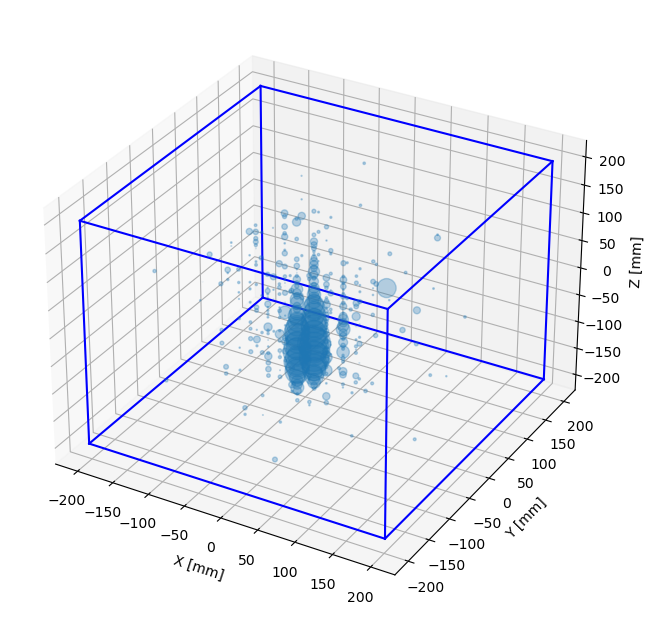

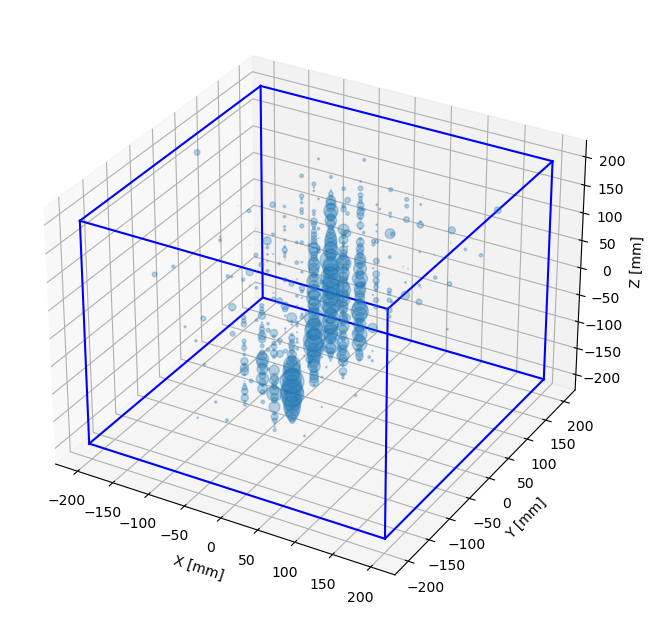

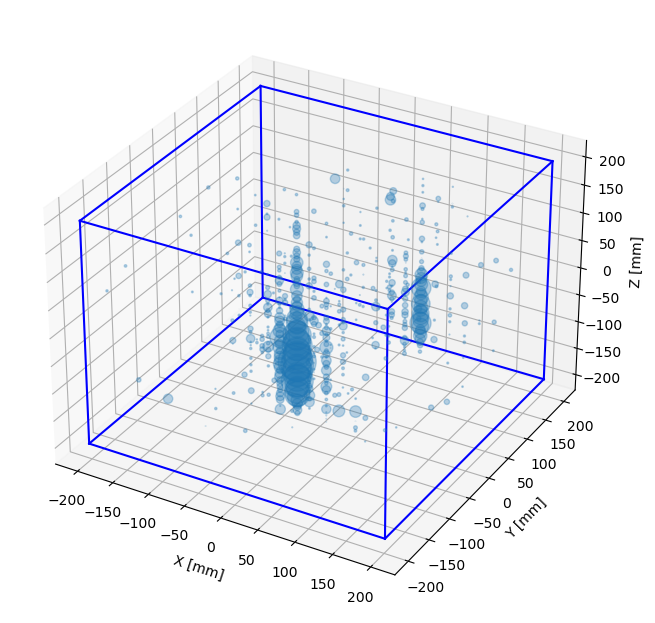

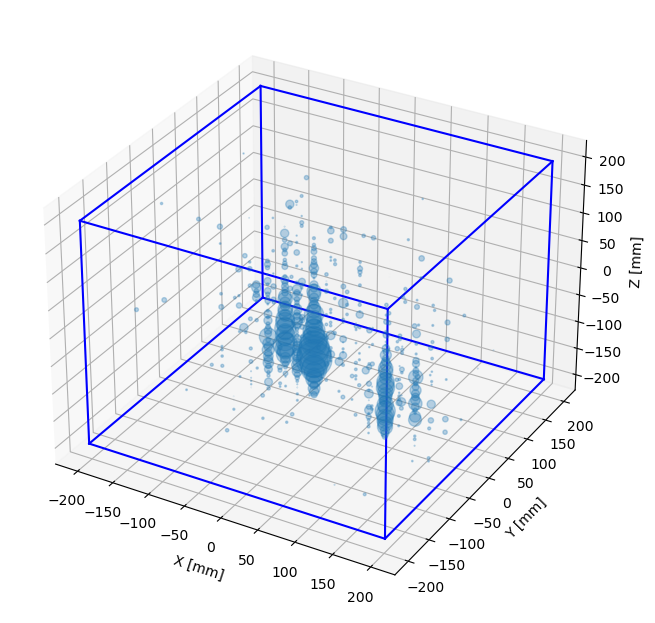

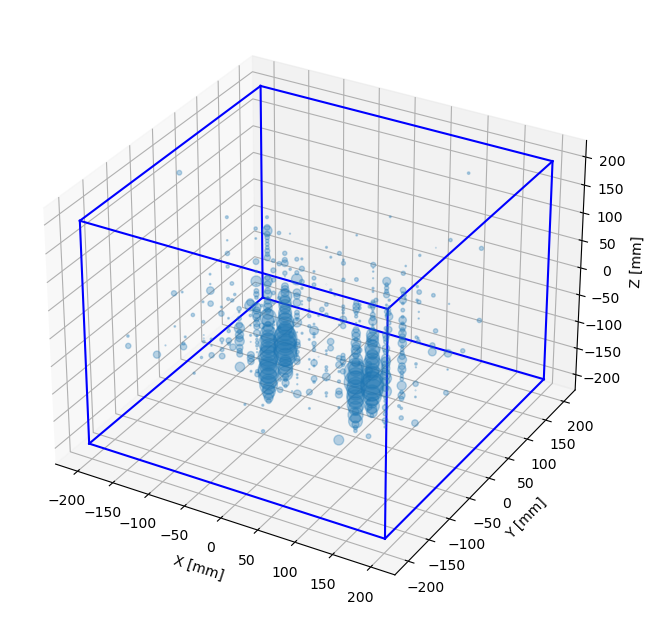

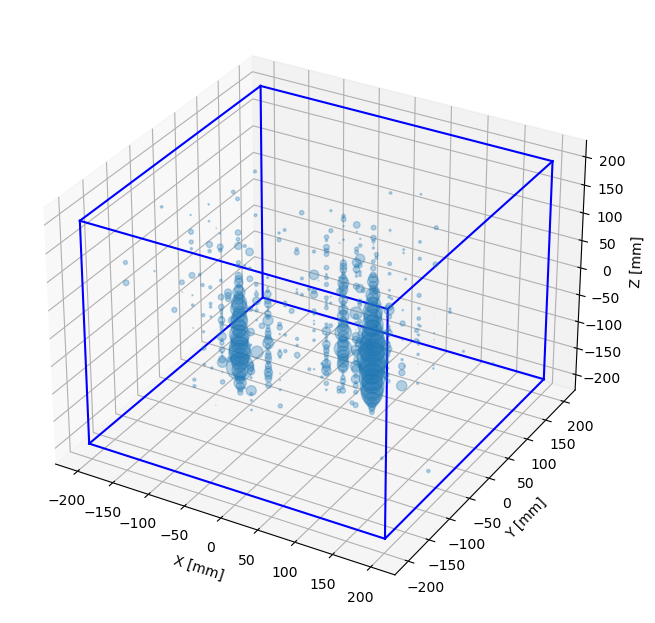

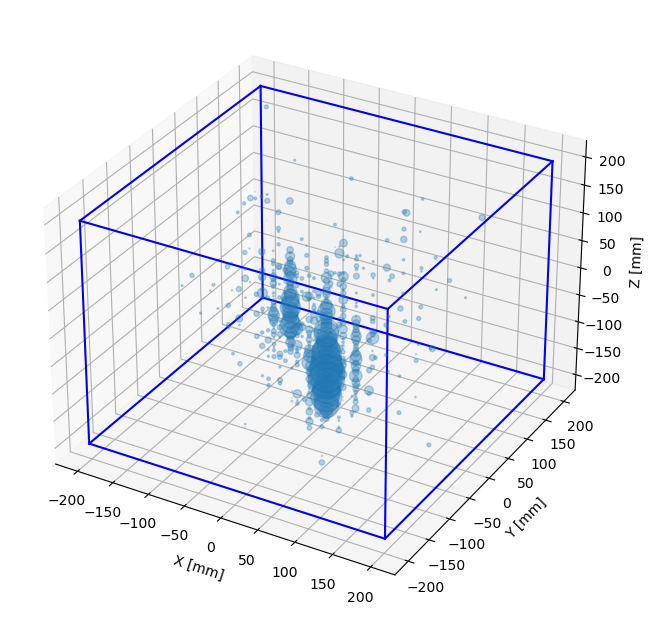

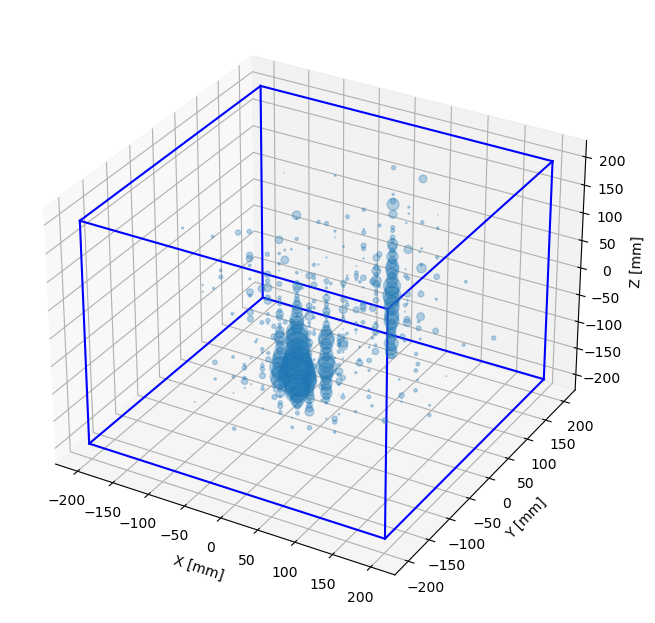

In [33]:
for i in range(10):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca(projection='3d')
    ax.scatter(position3d[0, :6700], position3d[1, :6700], position3d[2, :6700], s=deposit3d[:, i] * 10, alpha=0.3)
    xl = yl = 40.4 * 10 / 2
    zl = (2 * 66 + 4 * 67) / 2
    for s, e in combinations(np.array(list(product([-xl, xl], [-yl, yl], [-zl, zl]))), 2):
        if ((s - e) == 0).sum() == 2:
            ax.plot3D(*zip(s, e), color='b')
    ax.set_xlabel('X [mm]')
    ax.set_ylabel('Y [mm]')
    ax.set_zlabel('Z [mm]')

    plt.show()

In [34]:
energy2dpi0 = uproot.open(filepi0 + ':' + 'Energy2D')
xypi0 = uproot.open(filepi0 + ':' + 'XY')
truthpi0 = uproot.open(filepi0 + ':' + 'Truth')

In [35]:
deposit2dpi0 = np.vstack([energy2dpi0[e].array(library='np') for e in tqdm(energy2dpi0.keys())])
position2dpi0 = np.vstack([xypi0[e].array(library='np') for e in tqdm(xypi0.keys())])
truthexypi0 = np.vstack([truthpi0[e].array(library='np') for e in tqdm(truthpi0.keys())])

100%|██████████| 6/6 [00:00<00:00, 7182.03it/s]


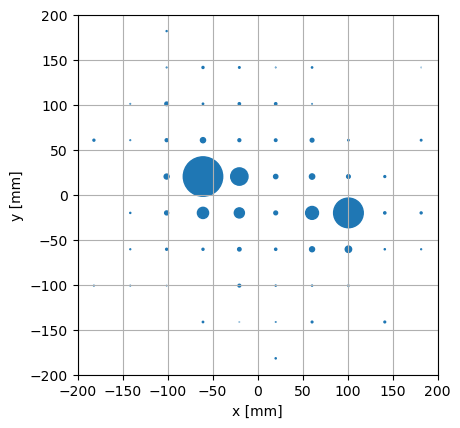

In [36]:
i = 0

fig = plt.figure(figsize=(4, 4))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.2, hspace=0.25)
ax = fig.add_subplot(gs[0, 0])
ax.grid()
ax.scatter(position2dpi0[0, :nCellxy], position2dpi0[1:, :nCellxy], s=deposit2dpi0[:, i])
ax.set_xlim(-200, 200)
ax.set_ylim(-200, 200)
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')

plt.show()

In [37]:
def loss(k, b, position, deposit):
    return np.average(np.abs(k * position[0] - position[1] + b) / np.sqrt(k ** 2 + 1), weights=deposit)

  0%|          | 0/2000 [00:00<?, ?it/s]

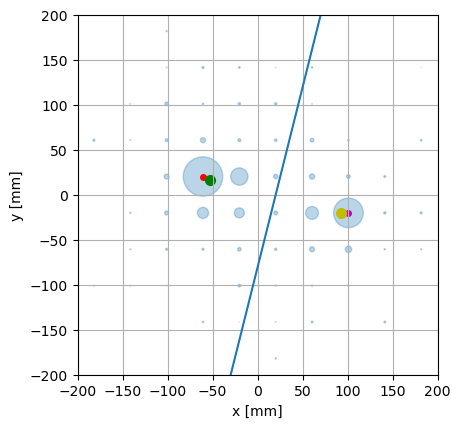

  0%|          | 1/2000 [00:00<03:52,  8.60it/s]

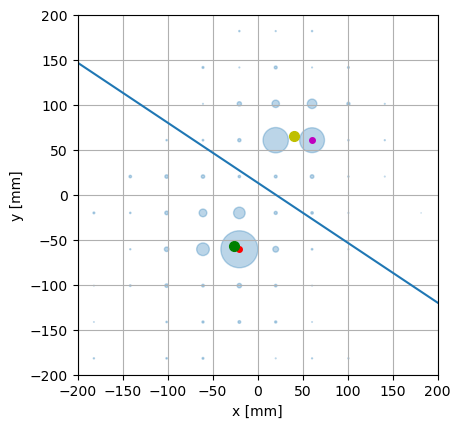

 25%|██▌       | 501/2000 [00:00<00:00, 2027.00it/s]

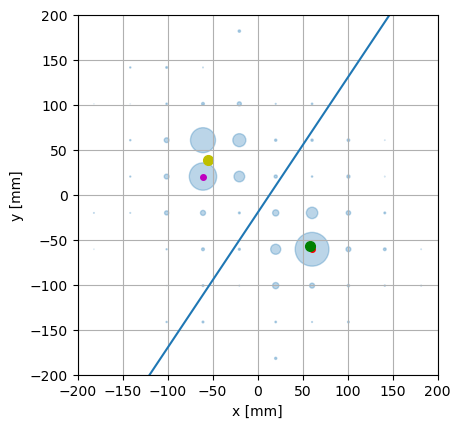

 50%|█████     | 1001/2000 [00:00<00:00, 2504.62it/s]

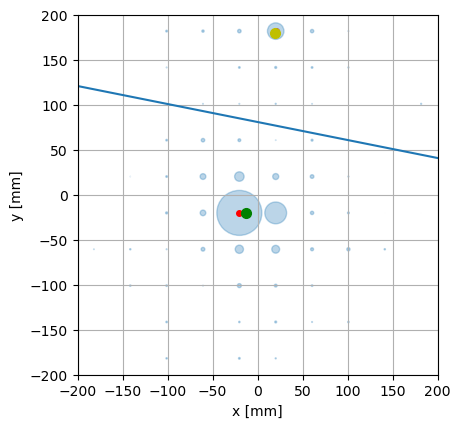

100%|██████████| 2000/2000 [00:00<00:00, 3012.26it/s]


In [38]:
k_list = np.full(deposit2dpi0.shape[1], np.nan)
b_list = np.full(deposit2dpi0.shape[1], np.nan)
energy_list = np.full((deposit2dpi0.shape[1], 2), np.nan)
xy_list = np.full((deposit2dpi0.shape[1], 4), np.nan)

for i in tqdm(range(deposit2dpi0.shape[1])):
    mainarg = deposit2dpi0[:, i].argmax()
    j = 2
    if deposit2dpi0[:, i].sum() < 1:
        continue
    while np.sqrt((position2dpi0[0, :nCellxy][mainarg] - position2dpi0[0, :nCellxy][deposit2dpi0[:, i].argsort()[-j]]) ** 2 + 
                  (position2dpi0[1, :nCellxy][mainarg] - position2dpi0[1, :nCellxy][deposit2dpi0[:, i].argsort()[-j]]) ** 2) < 130:
        j += 1
    altarg = deposit2dpi0[:, i].argsort()[-j]
    if deposit2dpi0[:, i][altarg] / (deposit2dpi0[:, i][mainarg] + deposit2dpi0[:, i][altarg]) < 0.05:
        continue
    x1 = position2dpi0[0, :nCellxy][mainarg]
    y1 = position2dpi0[1, :nCellxy][mainarg]
    x2 = position2dpi0[0, :nCellxy][altarg]
    y2 = position2dpi0[1, :nCellxy][altarg]
    k0 = -(x1 - x2) / (y1 - y2 + 1e-8)
    b0 = -((k0 * x1 - y1) + (k0 * x2 - y2)) / 2
    # m = Minuit(partial(loss, position=position2dpi0[:, :nCellxy], deposit=np.full(len(deposit2dpi0[:, i]), 1)), k=k0, b=b0, name=('k', 'b'))
    # m.errordef = Minuit.LIKELIHOOD
    # m.migrad()
    # m.migrad()
    # m.migrad()
    # m.hesse()
    # k_list[i] = m.values[0]
    # b_list[i] = m.values[1]
    k_list[i] = k0
    b_list[i] = b0
    
    vali00 = (position2dpi0[0, :nCellxy] * k_list[i] + b_list[i] - position2dpi0[1, :nCellxy] > 0)
    if position2dpi0[0, mainarg] * k_list[i] + b_list[i] - position2dpi0[1, mainarg] < 0:
        vali00 = ~vali00
    vali10 = position2dpi0[0, :nCellxy] * k_list[i] + b_list[i] - position2dpi0[1, :nCellxy] < 0
    if position2dpi0[0, altarg] * k_list[i] + b_list[i] - position2dpi0[1, altarg] > 0:
        vali10 = ~vali10
    
    vali01 = np.sqrt((position2dpi0[0, :nCellxy] - position2dpi0[0, :nCellxy][mainarg]) ** 2 + 
                     (position2dpi0[1, :nCellxy] - position2dpi0[1, :nCellxy][mainarg]) ** 2) < showerr
    vali11 = np.sqrt((position2dpi0[0, :nCellxy] - position2dpi0[0, :nCellxy][altarg]) ** 2 + 
                     (position2dpi0[1, :nCellxy] - position2dpi0[1, :nCellxy][altarg]) ** 2) < showerr
    vali0 = vali00 & vali01
    vali1 = vali10 & vali11
    
    energy_list[i, 0] = deposit2dpi0[:, i][vali0].sum()
    energy_list[i, 1] = deposit2dpi0[:, i][vali1].sum()
    xy_list[i, :2] = np.matmul(position2dpi0[:, :nCellxy][:, vali0], deposit2dpi0[:, i][vali0]) / energy_list[i, 0]
    xy_list[i, 2:] = np.matmul(position2dpi0[:, :nCellxy][:, vali1], deposit2dpi0[:, i][vali1]) / energy_list[i, 1]

    if i % 500 == 0:
        fig = plt.figure(figsize=(4, 4))
        # fig.tight_layout()
        gs = gridspec.GridSpec(1, 1, figure=fig, left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.2, hspace=0.25)
        ax = fig.add_subplot(gs[0, 0])
        ax.grid()
        ax.scatter(position2dpi0[0, :nCellxy], position2dpi0[1, :nCellxy], s=deposit2dpi0[:, i], alpha=0.3)
        ax.scatter(x1, y1, s=16, color='r')
        ax.scatter(x2, y2, s=16, color='m')
        ax.scatter(xy_list[i, 0], xy_list[i, 1], s=49, color='g')
        ax.scatter(xy_list[i, 2], xy_list[i, 3], s=49, color='y')
        ax.plot(np.linspace(-200, 200, 101), k0 * np.linspace(-200, 200, 101) + b0)
        ax.set_xlim(-200, 200)
        ax.set_ylim(-200, 200)
        ax.set_xlabel('x [mm]')
        ax.set_ylabel('y [mm]')

        plt.show()

In [39]:
print('Successfully reconstruction ratio is {:.2%}'.format((~np.isnan(energy_list[:, 0])).sum() / len(energy_list)))

Successfully reconstruction ratio is 83.40%


# $\pi^0$ proper mass reconstruction

In [40]:
vali = ~np.isnan(energy_list[:, 0])

pi0origin = np.array([0, 0, sourcez])

In [41]:
xyz1 = normalize((np.vstack([xy_list[:, 0], xy_list[:, 1], np.full(xy_list.shape[0], 0)]) - pi0origin[:, None])[:, vali], axis=0)
calienergy1 = califnc(energy_list[vali, 0])
gamma1 = np.vstack([calienergy1, calienergy1 * xyz1])

xyz2 = normalize((np.vstack([xy_list[:, 2], xy_list[:, 3], np.full(xy_list.shape[0], 0)]) - pi0origin[:, None])[:, vali], axis=0)
calienergy2 = califnc(energy_list[vali, 1])
gamma2 = np.vstack([calienergy2, calienergy2 * xyz2])

pi0 = gamma1 + gamma2

In [42]:
mass = np.sqrt(pi0[0] ** 2 - (pi0[1] ** 2 + pi0[2] ** 2 + pi0[3] ** 2))

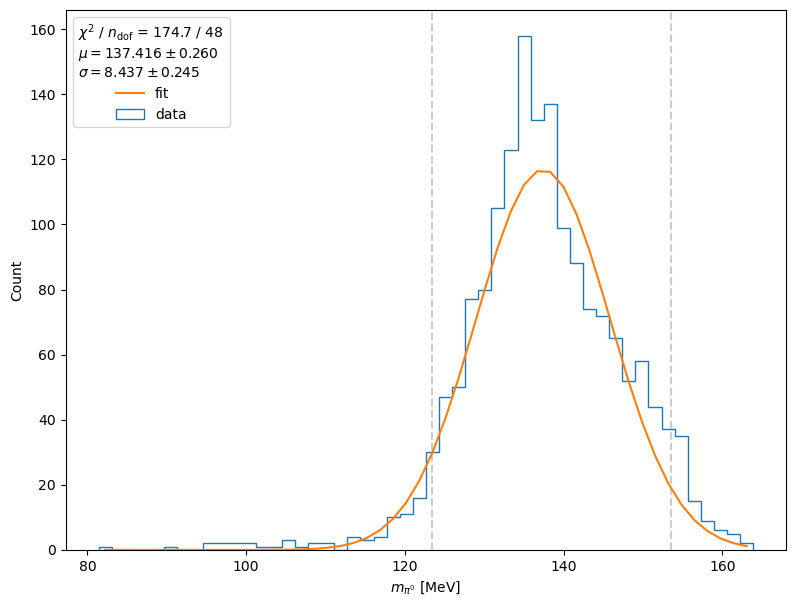

In [43]:
fig = plt.figure(figsize=(8, 6))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.2, hspace=0.25)
ax = fig.add_subplot(gs[0, 0])
bins = np.linspace(mass.min(), mass.max(), 51)
fitbins = np.linspace(np.quantile(mass, 0.05), np.quantile(mass, 0.95), 51) #@
h = ax.hist(mass, bins=bins, histtype='step', label='data')
ax.axvline(x=fitbins[0], color='k', linestyle='dashed', alpha=0.2)
ax.axvline(x=fitbins[-1], color='k', linestyle='dashed', alpha=0.2)
c, b = np.histogram(mass, bins=fitbins)
m = Minuit(partial(loglikelihood, obs=c, bins=fitbins), mu=mass.mean(), sigma=mass.std(ddof=-1), name=('mu', 'sigma'))
m.errordef = Minuit.LIKELIHOOD
m.limits['mu'] = (0, mass.max())
m.limits['sigma'] = (0, np.inf)
m.migrad()
m.migrad()
m.migrad()
m.hesse()

fit_info = [f'$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(bins) - 1 - m.nfit}', 
            f'$\mu = {m.values[0]:.3f} \\pm {m.errors[0]:.3f}$', f'$\sigma = {m.values[1]:.3f} \\pm {m.errors[1]:.3f}$']
ax.plot((bins[1:] + bins[:-1]) / 2, np.diff(norm.cdf(bins, loc=m.values[0], scale=m.values[1])) * c.sum(), label='fit')
ax.set_xlabel(r'$m_{\pi^0}$' + ' [MeV]')
ax.set_ylabel('Count')
ax.legend(title='\n'.join(fit_info))
plt.show()